In [26]:
from glob import glob
import pandas as pd
import json
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
fm.fontManager.addfont("./style/Lato/Lato-Regular.ttf")
plt.rcParams["font.family"] = "Lato"
plt.style.use("style/lato_modern.mplstyle")

# Auswertung der Ergebnisse

Auf dem Zukunftskongress 2025 haben wir interessierte Personen das Spiel Postkorb Panic spielen lassen. Die Spielenden waren Personen, die mit dem öffentlichen Sektor zu tun haben. Dazu zählen Personen aus dem öffentlichen Sektor und Personen, die Auftragnehmer für den öffentlichen Sektor sind.

Dieses Notebook macht eine Auswertung der Ergebnisse.

In [128]:
files = glob("../results/*.json")

In [129]:
files

['../results/Postkorb-Panic_Ergebnisse.json']

In [130]:
feedback = []

for file in files:
    with open(file) as f:
        feedback.extend(json.load(f))

In [131]:
feedback_data = []

for game_id, f in enumerate(feedback):
    for question_id, result in enumerate(f["gameResults"]):
        d = {col: val for col, val in f.items() if col != "gameResults"}
        d["game_id"] = game_id
        d["question_pos"] = question_id
        for col, value in result.items():
            d[col] = value
        feedback_data.append(d)

In [132]:
feedback_data = pd.DataFrame(feedback_data)

# Wie viele Spiele wurden gespielt?

In [133]:
feedback_data["game_id"].nunique()

80

# Alle E-Mail-Adressen mit Namen auslesen und ausgeben

In [35]:
feedback_data[feedback_data["email"] != ""][["name", "email"]].drop_duplicates().to_csv(
    "../results/emails.csv", index=False
)

# Auswertung

## Geschwindigkeit insgesamt mit und ohne KI

In [36]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["totalTime"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,120.828000,121.2,43.2,206.6
True,92.978182,79.0,16.8,473.1


In [76]:
def violinplot(data, col="correct", ylabel="Dauer pro Frage in Sekunden"):
    with_ai = data[data["aiMode"]][col]
    without_ai = data[~data["aiMode"]][col]

    plt.violinplot([without_ai], positions=[0], showmedians=True, showextrema=False)
    a = plt.violinplot([with_ai], positions=[1], showmedians=True, showextrema=False)
    for pc in a["bodies"]:  # type: ignore
        pc.set_color("#FFE600")
    a["cmedians"].set_colors("black")  # type: ignore

    plt.ylabel(ylabel)
    plt.xticks([0, 1], labels=["Ohne KI", "Mit KI"])
    plt.show()

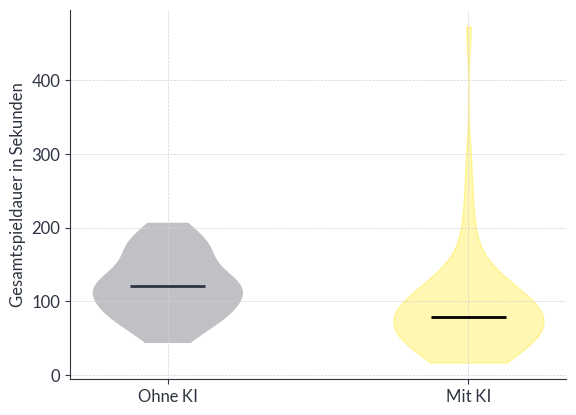

In [ ]:
games = feedback_data.drop_duplicates("game_id")
violinplot(games, col="totalTime", ylabel="Gesamtspieldauer in Sekunden")

## Geschwindigkeit pro Frage mit und ohne KI

In [68]:
feedback_data.groupby("aiMode")["responseTime"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,11.188916,9.6725,0.265,46.897
True,8.378587,5.8810,0.063,98.865


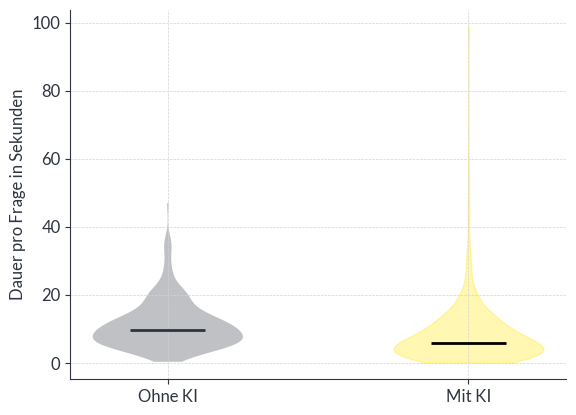

In [78]:
violinplot(feedback_data, col="responseTime", ylabel="Dauer pro Frage in Sekunden")

# Anzahl der korrekten Antworten mit und ohne KI

In [79]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["correct"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,7.080000,7.0,4,9
True,8.836364,9.0,5,10


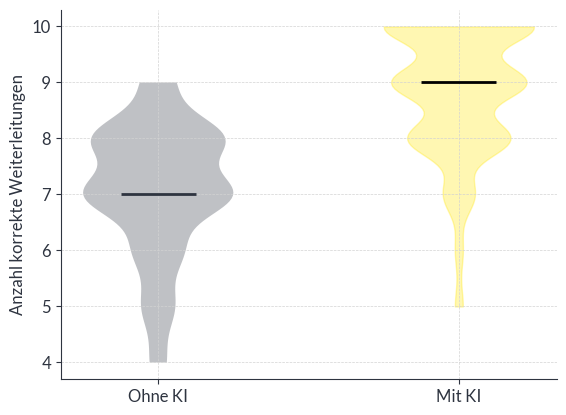

In [80]:
violinplot(feedback_data, col="correct", ylabel="Anzahl korrekte Weiterleitungen")

# Scores mit und ohne KI

In [ ]:
feedback_data.groupby("game_id").agg({"aiMode": "first", "score": "sum"}).groupby(
    "aiMode"
)["score"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,27.324000,25.3,5.6,71.5
True,54.510909,53.6,1.9,100.0


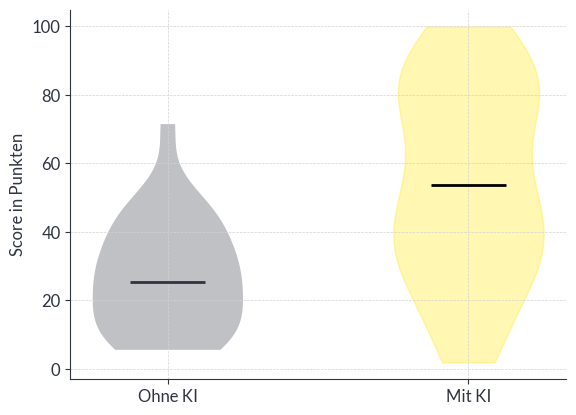

In [88]:
scores = feedback_data.groupby("game_id").agg({"aiMode": "first", "score": "sum"})
violinplot(scores, col="score", ylabel="Score in Punkten")

## Werden Teilnehmende mit der Zeit schneller? (KI vs. ohne KI)

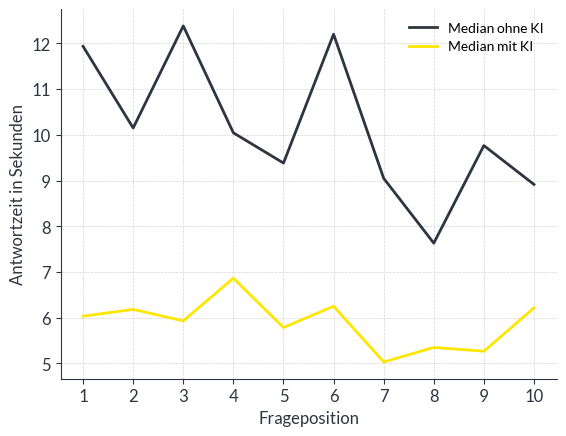

In [ ]:
# for game_id in feedback_data["game_id"].unique():
#     game = feedback_data[feedback_data["game_id"] == game_id]
#     color = "#FFE600" if game["aiMode"].all() else "#2e3440"
#     plt.plot(game["question_pos"], game["responseTime"], color=color, alpha=0.1)

median_with_ai = (
    feedback_data[feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .median()
)
median_without_ai = (
    feedback_data[~feedback_data["aiMode"]]
    .groupby("question_pos")["responseTime"]
    .median()
)
plt.plot(median_without_ai, label="Median ohne KI")
plt.plot(median_with_ai, color="#FFE600", label="Median mit KI")

plt.xlabel("Frageposition")
plt.ylabel("Antwortzeit in Sekunden")
plt.xticks(range(10), labels=range(1, 11))
plt.legend()

In [ ]:
feedback_data[~feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].median().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (ohne KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

# Welche Kategorie wird wie oft getippt?

In [ ]:
possible_depts = [
    "Finanzabteilung",
    "Rechtsabteilung",
    "Personalabteilung",
    "Leitungsebene",
    "Kundenservice",
]

In [ ]:
# Assuming feedback_data is already defined
incorrect_feedback = feedback_data[["correctDept", "playerChoice"]]

conf_matrix = confusion_matrix(
    incorrect_feedback["correctDept"], incorrect_feedback["playerChoice"]
)

conf_matrix_df = pd.DataFrame(conf_matrix, index=possible_depts, columns=possible_depts)

conf_matrix_df